First part : Simple GAN

In [1]:
#imports
import torch
import torchvision
import numpy as np

MNIST DATASET CLOTHES

In [2]:
train_clothes_dataset=torchvision.datasets.FashionMNIST(root='./data',train=True,download=True)

classes = ("t-shirt", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")



class Dataset

In [3]:

class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float)
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(train_clothes_dataset)
len(train)

C:\Users\ad99k\AppData\Local\Temp\ipykernel_6408\1514600936.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float)


60000

In [4]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]), torch.float32, tensor(1.), tensor(0.))

In [5]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

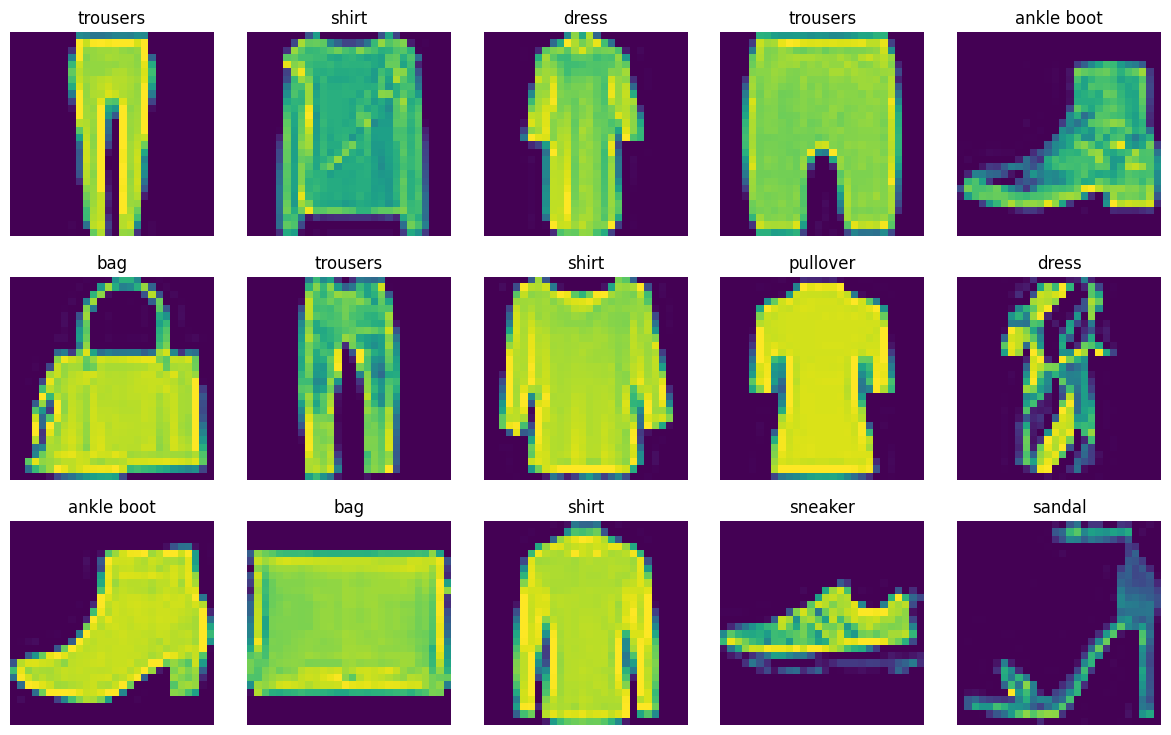

In [6]:
import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(28,28))
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [7]:
import torch.nn as nn

def block(n_in, n_out):
  return nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU(inplace=True)
  )

class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.fc1 = block(input_size, 150)
    self.fc2 = block(150, 100)
    self.fc3 = nn.Linear(100, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [8]:
n_in, n_out = 30, 28*28
generator = MLP(n_in, n_out)

In [9]:
output = generator(torch.randn(64, 30))
output.shape

torch.Size([64, 784])

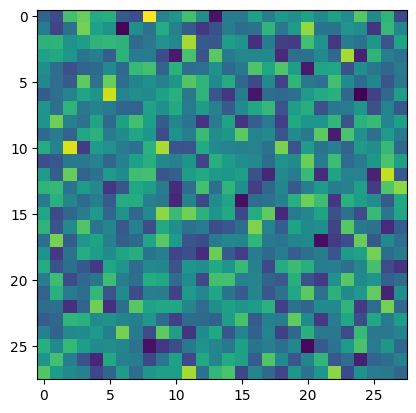

In [10]:
plt.imshow(output[0].reshape(28,28).detach().numpy())
plt.show()

In [11]:
discriminator = MLP(28*28, 1)
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

In [12]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):

  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    for X, y in progress_bar(dataloader, parent=mb):
      X, y = X, y 
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size))
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size))
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [13]:
hist = fit(generator, discriminator, dataloader)

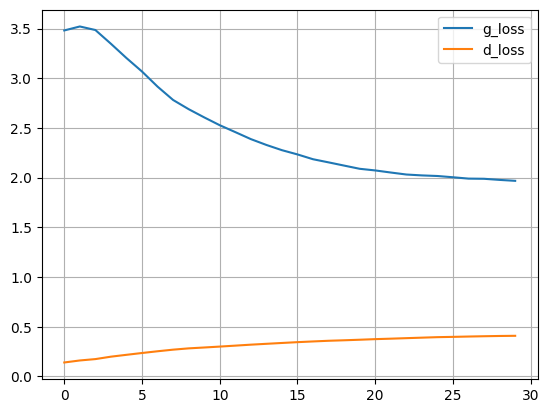

In [14]:
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

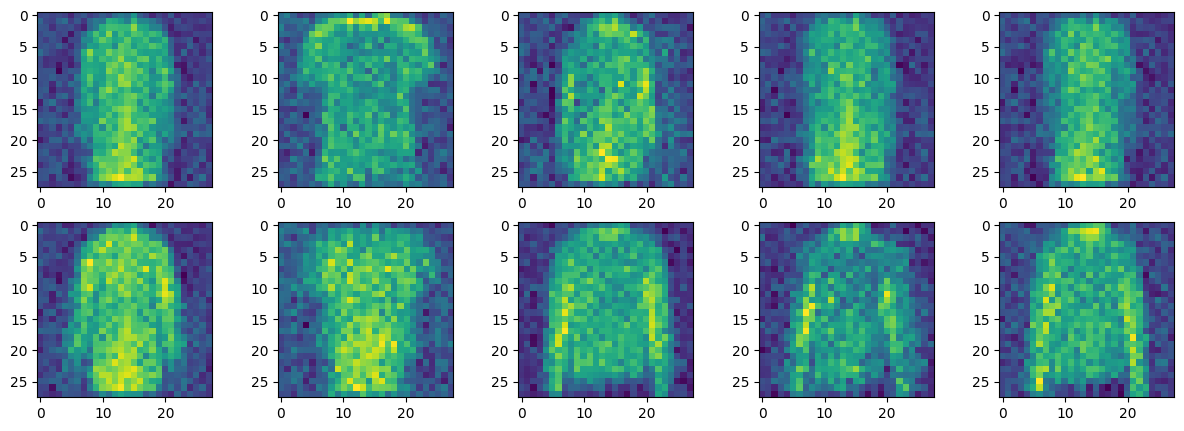

In [15]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size))
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

DCGANs

In [16]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 100
    self.inp = nn.Sequential(
        nn.Linear(self.input_size, 7*7*128),
        nn.BatchNorm1d(7*7*128),
    )
    self.main = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.inp(x)
    x = x.view(-1, 128, 7, 7)
    x = self.main(x)
    x = x.view(x.size(0), 28*28)
    return x

In [17]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 784])

In [18]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float)
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(train_clothes_dataset)
len(train)

60000

In [19]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]), torch.float32, tensor(1.), tensor(-1.))

In [20]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

In [21]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.out = nn.Sequential(
        nn.Linear(128*7*7, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # esperamos vectores a la entrada de 28*28
    x = x.view(x.size(0), 1, 28, 28)
    x = self.main(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x

In [22]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

In [23]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

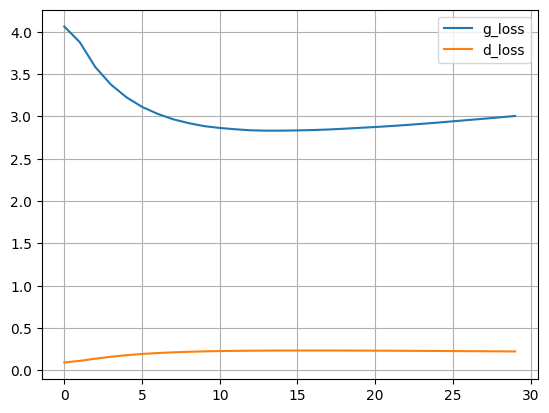

In [24]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

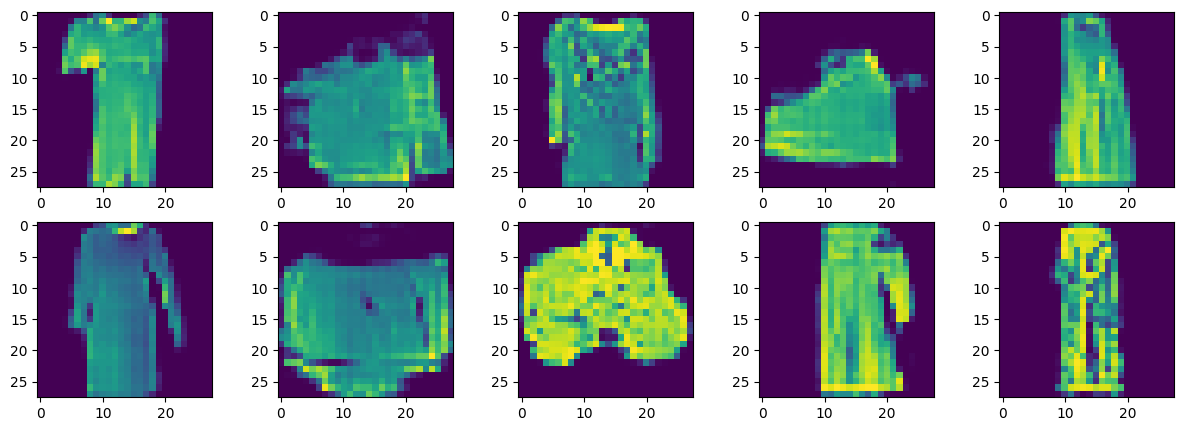

In [26]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size))
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

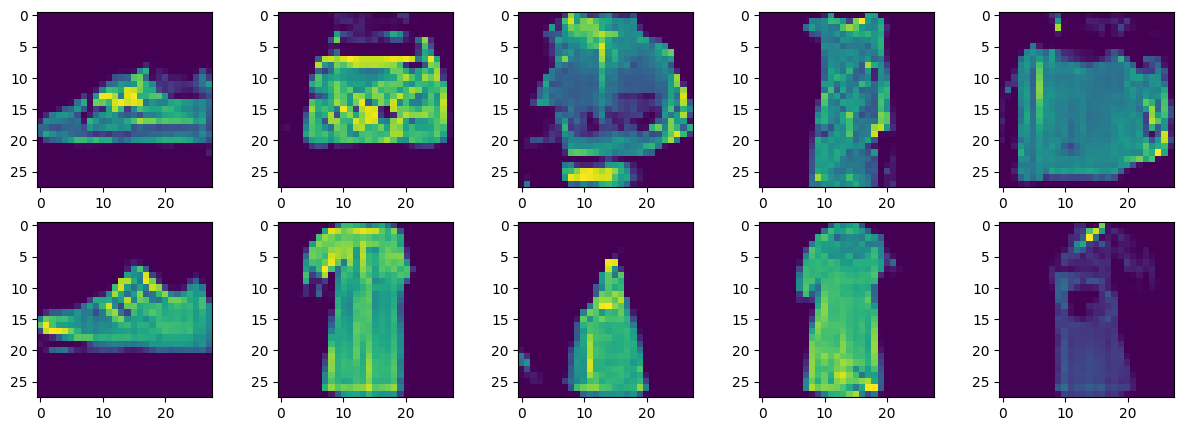

In [92]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size))
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

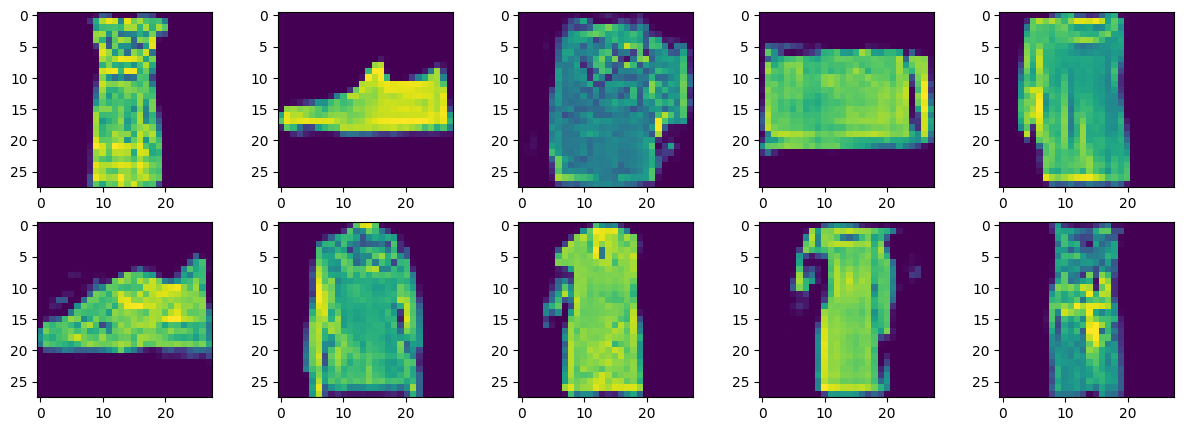

In [108]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size))
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

In [109]:
print(df)

      g_loss    d_loss
0   4.063567  0.092509
1   3.877238  0.111642
2   3.582734  0.136969
3   3.377188  0.160217
4   3.226647  0.178547
5   3.113677  0.192915
6   3.031305  0.204011
7   2.966920  0.212587
8   2.921174  0.218878
9   2.885676  0.223774
10  2.864226  0.227360
11  2.848590  0.229939
12  2.836387  0.231552
13  2.832149  0.232757
14  2.832493  0.233457
15  2.835206  0.233727
16  2.839705  0.233951
17  2.845989  0.233804
18  2.855254  0.233382
19  2.865788  0.232833
20  2.875258  0.232170
21  2.886718  0.231401
22  2.899165  0.230450
23  2.913202  0.229497
24  2.927212  0.228545
25  2.942850  0.227482
26  2.958241  0.226405
27  2.973474  0.225267
28  2.989671  0.224073
29  3.005720  0.222868


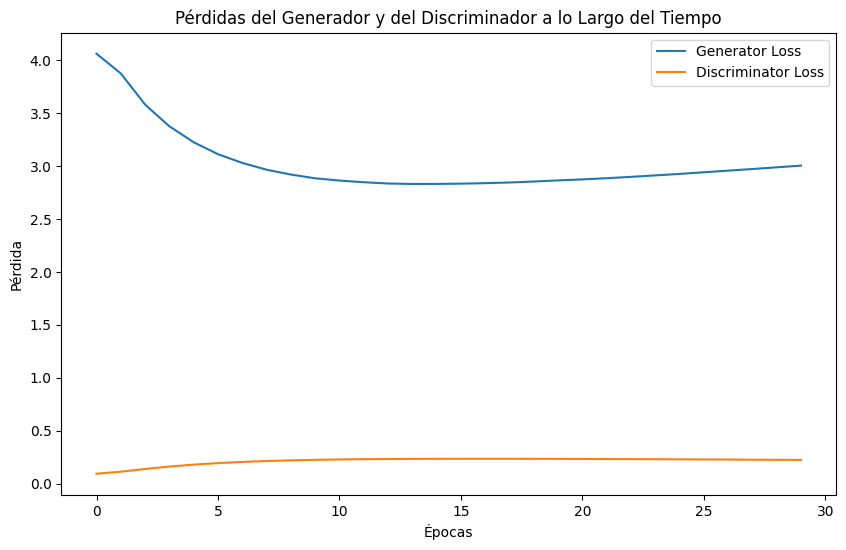

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['g_loss'], label='Generator Loss')
plt.plot(df['d_loss'], label='Discriminator Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdidas del Generador y del Discriminador a lo Largo del Tiempo')
plt.legend()
plt.show()

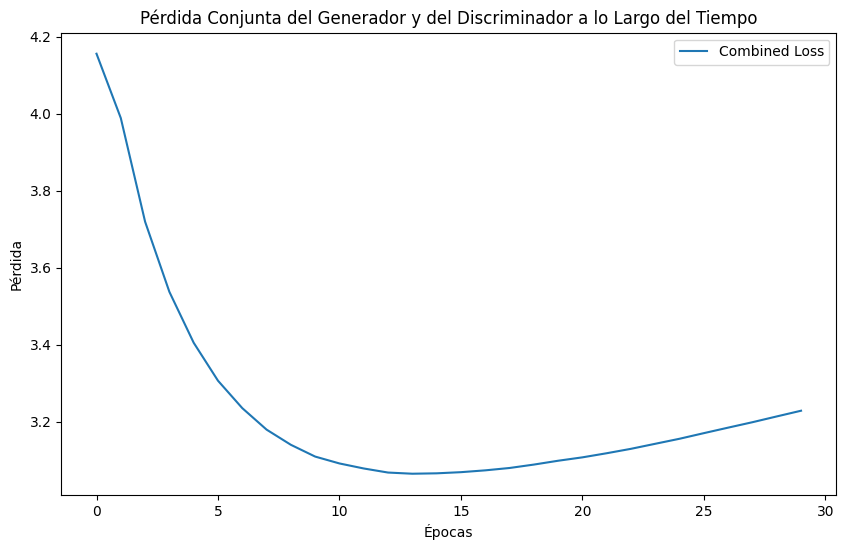

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(df['g_loss'] + df['d_loss'], label='Combined Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida Conjunta del Generador y del Discriminador a lo Largo del Tiempo')
plt.legend()
plt.show()

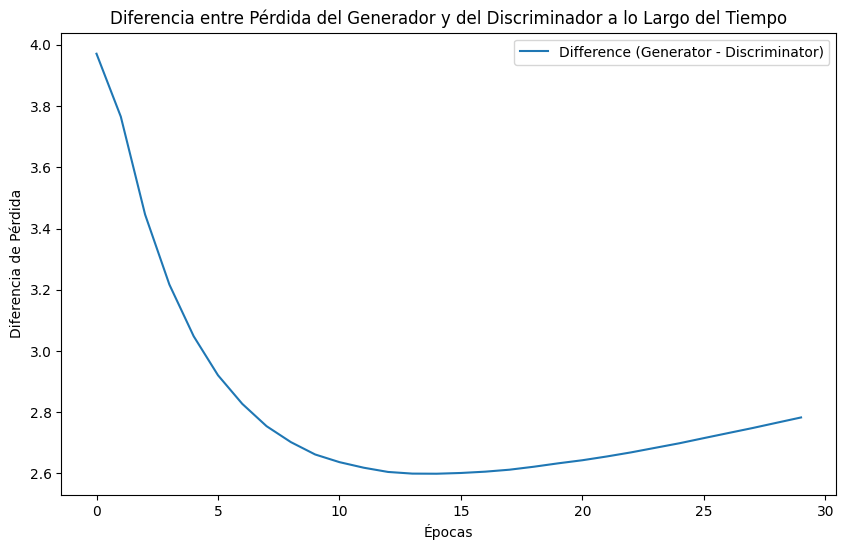

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(df['g_loss'] - df['d_loss'], label='Difference (Generator - Discriminator)')
plt.xlabel('Épocas')
plt.ylabel('Diferencia de Pérdida')
plt.title('Diferencia entre Pérdida del Generador y del Discriminador a lo Largo del Tiempo')
plt.legend()
plt.show()

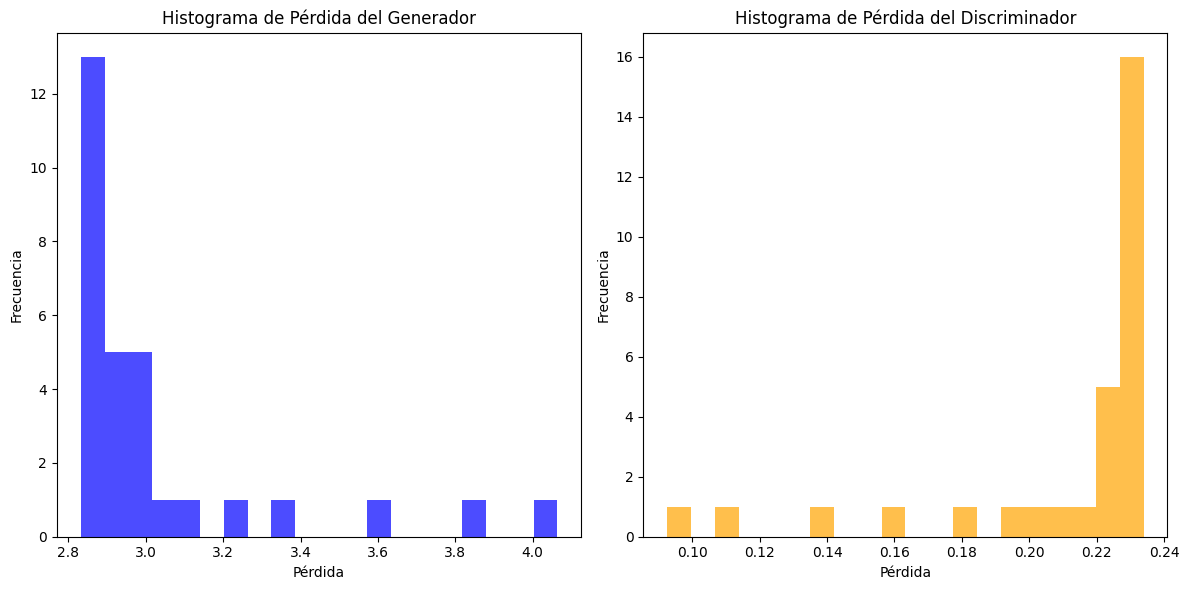

In [113]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['g_loss'], bins=20, color='blue', alpha=0.7)
plt.title('Histograma de Pérdida del Generador')
plt.xlabel('Pérdida')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(df['d_loss'], bins=20, color='orange', alpha=0.7)
plt.title('Histograma de Pérdida del Discriminador')
plt.xlabel('Pérdida')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

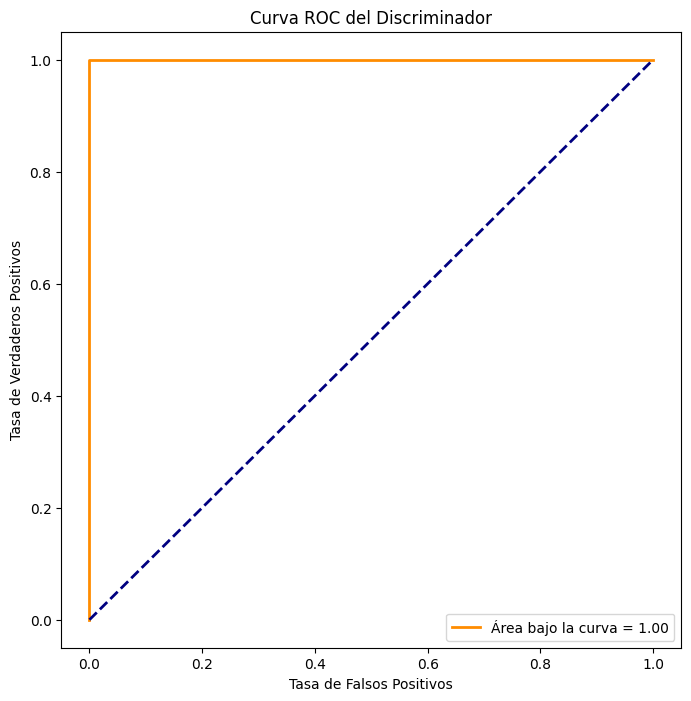

In [114]:
from sklearn.metrics import roc_curve, auc

# Crear etiquetas reales y predicciones del discriminador
labels = np.concatenate([np.ones(len(df)), np.zeros(len(df))])
predictions = np.concatenate([1 - df['d_loss'], df['d_loss']])

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

# Visualizar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área bajo la curva = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Discriminador')
plt.legend()
plt.show()